Running Model-2: 4500it [00:02, 1719.17it/s]<?, ?it/s]
Running Model-2: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


Fitting node Ridge-2...


Running Model-2: 490it [00:00, 1726.06it/s]           


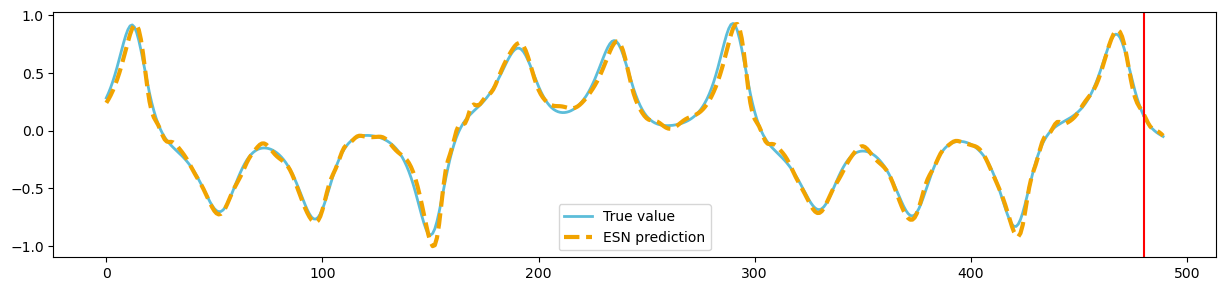

In [6]:
#Для построения архитектуры ESN использовалась библиотека reservoirPy, основанная на графовых вычислениях
import numpy as np
import math
import matplotlib.pyplot as plt
from reservoirpy.datasets import to_forecasting # разбиение на train/test
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge #узлы резервуара и считывающего слоя
from reservoirpy.observables import nrmse, rsquare
import json
from scipy.integrate import solve_ivp

length = 5000
train = 4500
forecast = 10

###ПОДГОТОВКА ДАННЫХ
#9
import warnings
from nolitsa import data

dt = 0.01
x0 = [0.1, -0.1, 1.0]

#000
x1 = data.lorenz(length=6500, sample=dt, x0=x0,
               sigma=16.0, beta=4.0, rho=45.92)[1]

#11
import copy
time = copy.deepcopy(x1) 
X1 = time[:,0] 
X1 = X1.reshape(6500,1) 
X1 = 2 * (X1 - X1.min()) / (X1.max() - X1.min()) - 1 
#000
    
X = X1[:5000]


def results(y_pred, y_test):
    fig = plt.figure(figsize=(15, 7))
    ax = plt.subplot(211)
    #ax.plot(np.arange(sample), y_test[len(y_test)-sample:], lw=2, label="True value", color="black")
    #ax.plot(np.arange(sample), y_pred[len(y_pred)-sample:], lw=3, label="ESN prediction", color="gray", linestyle="--")

    ax.plot(np.arange(len(y_test)), y_test, lw=2, label="True value", color="#5cbdd9")
    ax.plot(np.arange(len(y_pred)), y_pred, lw=3, label="ESN prediction", color="#f1a300", linestyle="--")
    ax.axvline(x=len(y_test)-forecast, color="red")  # Add vertical line
    ax.legend()
    plt.show()
    
###HERE0
from reservoirpy.datasets import to_forecasting

x, y = to_forecasting(X, forecast=forecast)

X_train1, y_train1 = x[:train], y[:train]
X_test1, y_test1 = x[train:], y[train:]

#Первый тестовый набор параметров 
units = 100
leak_rate = 0.3 #коэффициент утечки от 0 до 1
spectral_radius = 1.25 #от 0.1 до 1
input_scaling = 1.0
connectivity = 1.0 #от 0 до 1
input_connectivity = 0.2 #тоже %
regularization = 1e-8
seed = 1234

#узел резервуара
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
#выходной слой(считывающее устройство)
readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
#соединяем узлы и таким образом получаем модель 
esn = reservoir >> readout

#обучение модели
esn = esn.fit(X_train1, y_train1)
#делаем предсказание
y_pred1 = esn.run(X_test1, reset=False)
results(y_pred1, X[train+forecast:])
###HERE1

In [7]:
def rmse(x_test, x_sim):
        res = 0
        for i in range(len(x_sim)):
            res = res + (x_sim[i] - x_test[i])**2
        res = math.sqrt(res/len(x_sim))
        return res

rmse(y_pred1[-100:], X[-100:])

C:\Users\nicks\AppData\Local\Temp\ipykernel_7180\561460902.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim))


0.02967355170437901

In [8]:
BestRmse = 0.03752126275894335
BestHyp = np.empty((8, 1))

BestHyp[0] = 100
BestHyp[1] = 0.3
BestHyp[2] = 1.25
BestHyp[3] = 1.0
BestHyp[4] = 1.0
BestHyp[5] = 0.2
BestHyp[6] = 1e-8
BestHyp[7] = 1234

In [9]:
Seed = np.arange(1234, 1734, 300)
Regularization = np.arange(1e-8, 1.0, 0.5)
Input_connectivity = np.arange(0.01, 1.0, 0.5)
Connectivity = np.arange(0.01, 1.0, 0.5)
Input_scaling = np.arange(1.0, 5.0, 2.0)
Spectral_radius = np.arange(0.1, 1.0, 0.5)
Leak_rate = np.arange(0.05, 1.0, 0.5)
Units = np.arange(30, 1000, 400)

In [10]:
for q in range(len(Units)):
    for w in range(len(Leak_rate)):
        for e in range(len(Spectral_radius)):
            for r in range(len(Input_scaling)):
                for t in range(len(Connectivity)):
                    for z in range(len(Input_connectivity)):
                        for u in range(len(Regularization)):
                            for a in range(len(Seed)):
                                #Первый тестовый набор параметров 
                                units = Units[q]
                                leak_rate = Leak_rate[w] #коэффициент утечки от 0 до 1
                                spectral_radius = Spectral_radius[e] #от 0.1 до 1
                                input_scaling = Input_scaling[r]
                                connectivity = Connectivity[t] #от 0 до 1
                                input_connectivity = Input_connectivity[z] #тоже %
                                regularization = Regularization[u]
                                seed = Seed[a]

                                #узел резервуара
                                reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                                                    lr=leak_rate, rc_connectivity=connectivity,
                                                    input_connectivity=input_connectivity, seed=seed)
                                #выходной слой(считывающее устройство)
                                readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
                                #соединяем узлы и таким образом получаем модель 
                                esn = reservoir >> readout

                                #обучение модели
                                esn = esn.fit(X_train1, y_train1)
                                #делаем предсказание
                                y_pred1 = esn.run(X_test1, reset=False)
                                #results(y_pred1, X[train+forecast:])
                                Rmse = rmse(y_pred1[-100:], X[-100:])
                                if (Rmse<BestRmse):
                                    BestRmse = Rmse
                                    BestHyp[0] = Units[q]
                                    BestHyp[1] = Leak_rate[w]
                                    BestHyp[2] = Spectral_radius[e]
                                    BestHyp[3] = Input_scaling[r]
                                    BestHyp[4] = Connectivity[t]
                                    BestHyp[5] = Input_connectivity[z]
                                    BestHyp[6] = Regularization[u]
                                    BestHyp[7] = Seed[a]


Running Model-3: 4500it [00:01, 3431.12it/s]<?, ?it/s]
Running Model-3: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Fitting node Ridge-3...


Running Model-3: 490it [00:00, 5763.72it/s]           
C:\Users\nicks\AppData\Local\Temp\ipykernel_7180\561460902.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim))
Running Model-4: 4500it [00:00, 5037.00it/s]<?, ?it/s]
Running Model-4: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Fitting node Ridge-4...


Running Model-4: 490it [00:00, 8594.17it/s]           
Running Model-5: 4500it [00:00, 5804.97it/s]<?, ?it/s]
Running Model-5: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-5...


Running Model-5: 490it [00:00, 6282.33it/s]           
Running Model-6: 4500it [00:00, 5992.03it/s]<?, ?it/s]
Running Model-6: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-6...


Running Model-6: 490it [00:00, 5505.59it/s]           
Running Model-7: 4500it [00:00, 5753.11it/s]<?, ?it/s]
Running Model-7: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Fitting node Ridge-7...


Running Model-7: 490it [00:00, 6447.43it/s]           
Running Model-8: 4500it [00:00, 5843.25it/s]<?, ?it/s]
Running Model-8: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-8...


Running Model-8: 490it [00:00, 7205.70it/s]           
Running Model-9: 4500it [00:00, 7223.11it/s]<?, ?it/s]
Running Model-9: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-9...


Running Model-9: 490it [00:00, 5212.09it/s]           
Running Model-10: 4500it [00:00, 6326.94it/s]<?, ?it/s]
Running Model-10: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-10...


Running Model-10: 490it [00:00, 8166.64it/s]           
Running Model-11: 4500it [00:00, 6698.14it/s]<?, ?it/s]
Running Model-11: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-11...


Running Model-11: 490it [00:00, 6712.42it/s]           
Running Model-12: 4500it [00:00, 5575.19it/s]<?, ?it/s]
Running Model-12: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-12...


Running Model-12: 490it [00:00, 6049.09it/s]           
Running Model-13: 4500it [00:00, 6746.64it/s]<?, ?it/s]
Running Model-13: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-13...


Running Model-13: 490it [00:00, 7101.52it/s]           
Running Model-14: 4500it [00:00, 7301.03it/s]<?, ?it/s]
Running Model-14: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-14...


Running Model-14: 490it [00:00, 6203.06it/s]           
Running Model-15: 4500it [00:00, 6945.90it/s]<?, ?it/s]
Running Model-15: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-15...


Running Model-15: 490it [00:00, 6712.75it/s]           
Running Model-16: 4500it [00:00, 6529.59it/s]<?, ?it/s]
Running Model-16: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-16...


Running Model-16: 490it [00:00, 8597.65it/s]           
Running Model-17: 4500it [00:00, 6607.93it/s]<?, ?it/s]
Running Model-17: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-17...


Running Model-17: 490it [00:00, 6621.65it/s]           
Running Model-18: 4500it [00:00, 7108.98it/s]<?, ?it/s]
Running Model-18: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-18...


Running Model-18: 490it [00:00, 6805.42it/s]           
Running Model-19: 4500it [00:00, 6825.18it/s]<?, ?it/s]
Running Model-19: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-19...


Running Model-19: 490it [00:00, 7313.05it/s]           
Running Model-20: 4500it [00:00, 7064.35it/s]<?, ?it/s]
Running Model-20: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Fitting node Ridge-20...


Running Model-20: 490it [00:00, 7205.27it/s]           
Running Model-21: 4500it [00:00, 7388.34it/s]<?, ?it/s]
Running Model-21: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fitting node Ridge-21...


Running Model-21: 490it [00:00, 6712.55it/s]           
Running Model-22: 4500it [00:00, 5587.38it/s]<?, ?it/s]
Running Model-22: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Fitting node Ridge-22...


Running Model-22: 490it [00:00, 3110.12it/s]           
Running Model-23: 4500it [00:00, 4802.82it/s]<?, ?it/s]
Running Model-23: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Fitting node Ridge-23...


Running Model-23: 490it [00:00, 3798.47it/s]           
Running Model-24: 4500it [00:00, 5183.52it/s]<?, ?it/s]
Running Model-24: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Fitting node Ridge-24...


Running Model-24: 490it [00:00, 8167.26it/s]           
Running Model-25: 4500it [00:00, 6274.70it/s]<?, ?it/s]
Running Model-25: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-25...


Running Model-25: 490it [00:00, 6805.89it/s]           
Running Model-26: 4500it [00:00, 5463.75it/s]<?, ?it/s]
Running Model-26: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Fitting node Ridge-26...


Running Model-26: 490it [00:00, 3223.16it/s]           
Running Model-27: 4500it [00:00, 6028.43it/s]<?, ?it/s]
Running Model-27: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-27...


Running Model-27: 490it [00:00, 5974.39it/s]           
Running Model-28: 4500it [00:00, 6329.31it/s]<?, ?it/s]
Running Model-28: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-28...


Running Model-28: 490it [00:00, 7424.24it/s]           
Running Model-29: 4500it [00:00, 7328.94it/s]<?, ?it/s]
Running Model-29: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-29...


Running Model-29: 490it [00:00, 8166.93it/s]           
Running Model-30: 4500it [00:00, 6568.35it/s]<?, ?it/s]
Running Model-30: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-30...


Running Model-30: 490it [00:00, 7206.00it/s]           
Running Model-31: 4500it [00:00, 6595.42it/s]<?, ?it/s]
Running Model-31: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-31...


Running Model-31: 490it [00:00, 6711.89it/s]           
Running Model-32: 4500it [00:00, 7475.11it/s]<?, ?it/s]
Running Model-32: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-32...


Running Model-32: 490it [00:00, 6900.82it/s]           
Running Model-33: 4500it [00:00, 7398.85it/s]<?, ?it/s]
Running Model-33: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fitting node Ridge-33...


Running Model-33: 490it [00:00, 4298.74it/s]           
Running Model-34: 4500it [00:00, 6254.76it/s]<?, ?it/s]
Running Model-34: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-34...


Running Model-34: 490it [00:00, 3827.70it/s]           
Running Model-35: 4500it [00:00, 5660.50it/s]<?, ?it/s]
Running Model-35: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Fitting node Ridge-35...


Running Model-35: 490it [00:00, 6201.17it/s]           
Running Model-36: 4500it [00:00, 7732.07it/s]<?, ?it/s]
Running Model-36: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Fitting node Ridge-36...


Running Model-36: 490it [00:00, 7656.83it/s]           
Running Model-37: 4500it [00:00, 6901.96it/s]<?, ?it/s]
Running Model-37: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-37...


Running Model-37: 490it [00:00, 8034.09it/s]           
Running Model-38: 4500it [00:00, 6649.65it/s]<?, ?it/s]
Running Model-38: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-38...


Running Model-38: 490it [00:00, 8168.65it/s]           
Running Model-39: 4500it [00:00, 6423.85it/s]<?, ?it/s]
Running Model-39: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Fitting node Ridge-39...


Running Model-39: 490it [00:00, 6201.24it/s]           
Running Model-40: 4500it [00:00, 6244.85it/s]<?, ?it/s]
Running Model-40: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-40...


Running Model-40: 490it [00:00, 7538.62it/s]           
Running Model-41: 4500it [00:00, 6164.52it/s]<?, ?it/s]
Running Model-41: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-41...


Running Model-41: 490it [00:00, 8032.24it/s]           
Running Model-42: 4500it [00:00, 7209.73it/s]<?, ?it/s]
Running Model-42: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-42...


Running Model-42: 490it [00:00, 8597.11it/s]           
Running Model-43: 4500it [00:00, 7188.52it/s]<?, ?it/s]
Running Model-43: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-43...


Running Model-43: 490it [00:00, 5245.64it/s]           
Running Model-44: 4500it [00:00, 5711.21it/s]<?, ?it/s]
Running Model-44: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-44...


Running Model-44: 490it [00:00, 3629.72it/s]           
Running Model-45: 4500it [00:01, 4443.48it/s]<?, ?it/s]
Running Model-45: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Fitting node Ridge-45...


Running Model-45: 490it [00:00, 3550.22it/s]           
Running Model-46: 4500it [00:00, 5912.04it/s]<?, ?it/s]
Running Model-46: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Fitting node Ridge-46...


Running Model-46: 490it [00:00, 6533.43it/s]           
Running Model-47: 4500it [00:00, 6987.57it/s]<?, ?it/s]
Running Model-47: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-47...


Running Model-47: 490it [00:00, 5904.14it/s]           
Running Model-48: 4500it [00:00, 6047.87it/s]<?, ?it/s]
Running Model-48: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Fitting node Ridge-48...


Running Model-48: 490it [00:00, 7101.13it/s]           
Running Model-49: 4500it [00:00, 7475.14it/s]<?, ?it/s]
Running Model-49: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-49...


Running Model-49: 490it [00:00, 7205.27it/s]           
Running Model-50: 4500it [00:00, 7323.33it/s]<?, ?it/s]
Running Model-50: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-50...


Running Model-50: 490it [00:00, 7537.24it/s]           
Running Model-51: 4500it [00:00, 7009.24it/s]<?, ?it/s]
Running Model-51: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-51...


Running Model-51: 490it [00:00, 6935.73it/s]           
Running Model-52: 4500it [00:00, 6929.03it/s]<?, ?it/s]
Running Model-52: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-52...


Running Model-52: 490it [00:00, 7903.34it/s]           
Running Model-53: 4500it [00:00, 6353.93it/s]<?, ?it/s]
Running Model-53: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-53...


Running Model-53: 490it [00:00, 8750.82it/s]           
Running Model-54: 4500it [00:00, 7575.78it/s]<?, ?it/s]
Running Model-54: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-54...


Running Model-54: 490it [00:00, 8165.99it/s]           
Running Model-55: 4500it [00:00, 6901.80it/s]<?, ?it/s]
Running Model-55: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-55...


Running Model-55: 490it [00:00, 7656.09it/s]           
Running Model-56: 4500it [00:00, 4843.86it/s]<?, ?it/s]
Running Model-56: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Fitting node Ridge-56...


Running Model-56: 490it [00:00, 5212.34it/s]           
Running Model-57: 4500it [00:01, 4477.61it/s]<?, ?it/s]
Running Model-57: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Fitting node Ridge-57...


Running Model-57: 490it [00:00, 7542.77it/s]           
Running Model-58: 4500it [00:00, 6856.80it/s]<?, ?it/s]
Running Model-58: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-58...


Running Model-58: 490it [00:00, 7537.24it/s]           
Running Model-59: 4500it [00:00, 5703.45it/s]<?, ?it/s]
Running Model-59: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Fitting node Ridge-59...


Running Model-59: 490it [00:00, 8447.22it/s]           
Running Model-60: 4500it [00:00, 7692.32it/s]<?, ?it/s]
Running Model-60: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-60...


Running Model-60: 490it [00:00, 7903.56it/s]           
Running Model-61: 4500it [00:00, 6617.59it/s]<?, ?it/s]
Running Model-61: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-61...


Running Model-61: 490it [00:00, 3474.72it/s]           
Running Model-62: 4500it [00:00, 6181.19it/s]<?, ?it/s]
Running Model-62: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-62...


Running Model-62: 490it [00:00, 6620.18it/s]           
Running Model-63: 4500it [00:00, 6680.51it/s]<?, ?it/s]
Running Model-63: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-63...


Running Model-63: 490it [00:00, 8032.62it/s]           
Running Model-64: 4500it [00:00, 6944.53it/s]<?, ?it/s]
Running Model-64: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-64...


Running Model-64: 490it [00:00, 7656.23it/s]           
Running Model-65: 4500it [00:00, 6302.29it/s]<?, ?it/s]
Running Model-65: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-65...


Running Model-65: 490it [00:00, 6362.64it/s]           
Running Model-66: 4500it [00:00, 7258.09it/s]<?, ?it/s]
Running Model-66: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-66...


Running Model-66: 490it [00:00, 6364.18it/s]           
Running Model-67: 4500it [00:00, 7524.89it/s]<?, ?it/s]
Running Model-67: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fitting node Ridge-67...


Running Model-67: 490it [00:00, 7537.93it/s]           
Running Model-68: 4500it [00:00, 6130.83it/s]<?, ?it/s]
Running Model-68: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-68...


Running Model-68: 490it [00:00, 8593.48it/s]           
Running Model-69: 4500it [00:00, 6007.06it/s]<?, ?it/s]
Running Model-69: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-69...


Running Model-69: 490it [00:00, 7537.82it/s]           
Running Model-70: 4500it [00:00, 7006.86it/s]<?, ?it/s]
Running Model-70: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-70...


Running Model-70: 490it [00:00, 7103.68it/s]           
Running Model-71: 4500it [00:00, 6986.46it/s]<?, ?it/s]
Running Model-71: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-71...


Running Model-71: 490it [00:00, 2987.80it/s]           
Running Model-72: 4500it [00:00, 6955.14it/s]<?, ?it/s]
Running Model-72: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-72...


Running Model-72: 490it [00:00, 5325.69it/s]           
Running Model-73: 4500it [00:00, 7352.80it/s]<?, ?it/s]
Running Model-73: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-73...


Running Model-73: 490it [00:00, 5505.49it/s]           
Running Model-74: 4500it [00:00, 5867.06it/s]<?, ?it/s]
Running Model-74: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-74...


Running Model-74: 490it [00:00, 5051.59it/s]           
Running Model-75: 4500it [00:00, 6545.88it/s]<?, ?it/s]
Running Model-75: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-75...


Running Model-75: 490it [00:00, 7655.75it/s]           
Running Model-76: 4500it [00:00, 6700.60it/s]<?, ?it/s]
Running Model-76: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-76...


Running Model-76: 490it [00:00, 6447.55it/s]           
Running Model-77: 4500it [00:00, 7487.62it/s]<?, ?it/s]
Running Model-77: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-77...


Running Model-77: 490it [00:00, 7424.59it/s]           
Running Model-78: 4500it [00:00, 6859.67it/s]<?, ?it/s]
Running Model-78: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-78...


Running Model-78: 490it [00:00, 7777.08it/s]           
Running Model-79: 4500it [00:00, 5249.78it/s]<?, ?it/s]
Running Model-79: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Fitting node Ridge-79...


Running Model-79: 490it [00:00, 5212.64it/s]           
Running Model-80: 4500it [00:00, 4829.33it/s]<?, ?it/s]
Running Model-80: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Fitting node Ridge-80...


Running Model-80: 490it [00:00, 4455.12it/s]           
Running Model-81: 4500it [00:01, 3892.04it/s]<?, ?it/s]
Running Model-81: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Fitting node Ridge-81...


Running Model-81: 490it [00:00, 7655.92it/s]           
Running Model-82: 4500it [00:00, 5806.32it/s]<?, ?it/s]
Running Model-82: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Fitting node Ridge-82...


Running Model-82: 490it [00:00, 5383.62it/s]           
Running Model-83: 4500it [00:00, 5721.95it/s]<?, ?it/s]
Running Model-83: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-83...


Running Model-83: 490it [00:00, 6446.34it/s]           
Running Model-84: 4500it [00:00, 6666.66it/s]<?, ?it/s]
Running Model-84: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-84...


Running Model-84: 490it [00:00, 6447.15it/s]           
Running Model-85: 4500it [00:00, 6024.05it/s]<?, ?it/s]
Running Model-85: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Fitting node Ridge-85...


Running Model-85: 490it [00:00, 5567.08it/s]           
Running Model-86: 4500it [00:00, 7533.94it/s]<?, ?it/s]
Running Model-86: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fitting node Ridge-86...


Running Model-86: 490it [00:00, 9246.04it/s]           
Running Model-87: 4500it [00:00, 7678.07it/s]<?, ?it/s]
Running Model-87: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-87...


Running Model-87: 490it [00:00, 7779.11it/s]           
Running Model-88: 4500it [00:00, 6515.06it/s]<?, ?it/s]
Running Model-88: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Fitting node Ridge-88...


Running Model-88: 490it [00:00, 8597.65it/s]           
Running Model-89: 4500it [00:00, 6631.27it/s]<?, ?it/s]
Running Model-89: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-89...


Running Model-89: 490it [00:00, 7425.00it/s]           
Running Model-90: 4500it [00:00, 6698.15it/s]<?, ?it/s]
Running Model-90: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-90...


Running Model-90: 490it [00:00, 2563.22it/s]           
Running Model-91: 4500it [00:00, 6305.26it/s]<?, ?it/s]
Running Model-91: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-91...


Running Model-91: 490it [00:00, 7536.80it/s]           
Running Model-92: 4500it [00:00, 5991.81it/s]<?, ?it/s]
Running Model-92: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-92...


Running Model-92: 490it [00:00, 6805.67it/s]           
Running Model-93: 4500it [00:00, 4560.88it/s]<?, ?it/s]
Running Model-93: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Fitting node Ridge-93...


Running Model-93: 490it [00:00, 5050.83it/s]           
Running Model-94: 4500it [00:00, 6064.14it/s]<?, ?it/s]
Running Model-94: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Fitting node Ridge-94...


Running Model-94: 490it [00:00, 6805.96it/s]           
Running Model-95: 4500it [00:00, 4955.35it/s]<?, ?it/s]
Running Model-95: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Fitting node Ridge-95...


Running Model-95: 490it [00:00, 8908.04it/s]           
Running Model-96: 4500it [00:00, 7537.56it/s]<?, ?it/s]
Running Model-96: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-96...


Running Model-96: 490it [00:00, 7422.80it/s]           
Running Model-97: 4500it [00:00, 5552.86it/s]<?, ?it/s]
Running Model-97: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Fitting node Ridge-97...


Running Model-97: 490it [00:00, 4665.65it/s]           
Running Model-98: 4500it [00:01, 3214.73it/s]<?, ?it/s]
Running Model-98: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Fitting node Ridge-98...


Running Model-98: 490it [00:00, 6048.43it/s]           
Running Model-99: 4500it [00:00, 6837.94it/s]<?, ?it/s]
Running Model-99: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-99...


Running Model-99: 490it [00:00, 8032.21it/s]           
Running Model-100: 4500it [00:00, 7920.74it/s]<?, ?it/s]
Running Model-100: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


Fitting node Ridge-100...


Running Model-100: 490it [00:00, 6631.67it/s]           
Running Model-101: 4500it [00:00, 6868.05it/s]<?, ?it/s]
Running Model-101: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-101...


Running Model-101: 490it [00:00, 7424.51it/s]           
Running Model-102: 4500it [00:00, 6880.74it/s]<?, ?it/s]
Running Model-102: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-102...


Running Model-102: 490it [00:00, 8751.04it/s]           
Running Model-103: 4500it [00:00, 7479.40it/s]<?, ?it/s]
Running Model-103: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fitting node Ridge-103...


Running Model-103: 490it [00:00, 7472.43it/s]           
Running Model-104: 4500it [00:00, 7569.80it/s]<?, ?it/s]
Running Model-104: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-104...


Running Model-104: 490it [00:00, 4083.43it/s]           
Running Model-105: 4500it [00:00, 7684.26it/s]<?, ?it/s]
Running Model-105: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-105...


Running Model-105: 490it [00:00, 6125.13it/s]           
Running Model-106: 4500it [00:00, 4616.11it/s]<?, ?it/s]
Running Model-106: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Fitting node Ridge-106...


Running Model-106: 490it [00:00, 5104.42it/s]           
Running Model-107: 4500it [00:00, 7450.42it/s]<?, ?it/s]
Running Model-107: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-107...


Running Model-107: 490it [00:00, 7902.95it/s]           
Running Model-108: 4500it [00:00, 5436.62it/s]<?, ?it/s]
Running Model-108: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Fitting node Ridge-108...


Running Model-108: 490it [00:00, 7657.46it/s]           
Running Model-109: 4500it [00:00, 6343.89it/s]<?, ?it/s]
Running Model-109: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-109...


Running Model-109: 490it [00:00, 8166.77it/s]           
Running Model-110: 4500it [00:00, 5235.29it/s]<?, ?it/s]
Running Model-110: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Fitting node Ridge-110...


Running Model-110: 490it [00:00, 5383.83it/s]           
Running Model-111: 4500it [00:00, 4746.45it/s]<?, ?it/s]
Running Model-111: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Fitting node Ridge-111...


Running Model-111: 490it [00:00, 5974.74it/s]           
Running Model-112: 4500it [00:01, 4240.81it/s]<?, ?it/s]
Running Model-112: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Fitting node Ridge-112...


Running Model-112: 490it [00:00, 3223.60it/s]           
Running Model-113: 4500it [00:00, 7580.56it/s]<?, ?it/s]
Running Model-113: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-113...


Running Model-113: 490it [00:00, 7775.69it/s]           
Running Model-114: 4500it [00:00, 4710.73it/s]<?, ?it/s]
Running Model-114: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Fitting node Ridge-114...


Running Model-114: 490it [00:00, 6365.18it/s]           
Running Model-115: 4500it [00:00, 5653.35it/s]<?, ?it/s]
Running Model-115: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Fitting node Ridge-115...


Running Model-115: 490it [00:00, 7902.89it/s]           
Running Model-116: 4500it [00:00, 7177.07it/s]<?, ?it/s]
Running Model-116: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-116...


Running Model-116: 490it [00:00, 3425.48it/s]           
Running Model-117: 4500it [00:00, 5555.95it/s]<?, ?it/s]
Running Model-117: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-117...


Running Model-117: 490it [00:00, 6394.13it/s]           
Running Model-118: 4500it [00:00, 7669.68it/s]<?, ?it/s]
Running Model-118: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-118...


Running Model-118: 490it [00:00, 6282.35it/s]           
Running Model-119: 4500it [00:00, 7215.64it/s]<?, ?it/s]
Running Model-119: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-119...


Running Model-119: 490it [00:00, 8445.83it/s]           
Running Model-120: 4500it [00:00, 6559.80it/s]<?, ?it/s]
Running Model-120: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-120...


Running Model-120: 490it [00:00, 6901.47it/s]           
Running Model-121: 4500it [00:00, 6849.29it/s]<?, ?it/s]
Running Model-121: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-121...


Running Model-121: 490it [00:00, 8032.40it/s]           
Running Model-122: 4500it [00:00, 7594.85it/s]<?, ?it/s]
Running Model-122: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-122...


Running Model-122: 490it [00:00, 8032.55it/s]           
Running Model-123: 4500it [00:00, 6859.70it/s]<?, ?it/s]
Running Model-123: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-123...


Running Model-123: 490it [00:00, 8302.60it/s]           
Running Model-124: 4500it [00:00, 5983.90it/s]<?, ?it/s]
Running Model-124: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-124...


Running Model-124: 490it [00:00, 3656.79it/s]           
Running Model-125: 4500it [00:00, 5395.65it/s]<?, ?it/s]
Running Model-125: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Fitting node Ridge-125...


Running Model-125: 490it [00:00, 4188.46it/s]           
Running Model-126: 4500it [00:00, 4934.29it/s]<?, ?it/s]
Running Model-126: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Fitting node Ridge-126...


Running Model-126: 490it [00:00, 7902.55it/s]           
Running Model-127: 4500it [00:00, 6000.02it/s]<?, ?it/s]
Running Model-127: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-127...


Running Model-127: 490it [00:00, 2578.67it/s]           
Running Model-128: 4500it [00:00, 4891.34it/s]<?, ?it/s]
Running Model-128: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Fitting node Ridge-128...


Running Model-128: 490it [00:00, 7900.70it/s]           
Running Model-129: 4500it [00:00, 6456.37it/s]<?, ?it/s]
Running Model-129: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Fitting node Ridge-129...


Running Model-129: 490it [00:00, 3062.18it/s]           
Running Model-130: 4500it [00:00, 6428.65it/s]<?, ?it/s]
Running Model-130: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-130...


Running Model-130: 490it [00:00, 7776.43it/s]           
Running Model-131: 4500it [00:00, 6537.87it/s]<?, ?it/s]
Running Model-131: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-131...


Running Model-131: 490it [00:00, 5630.72it/s]           
Running Model-132: 4500it [00:00, 4576.61it/s]<?, ?it/s]
Running Model-132: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-132...


Running Model-132: 490it [00:00, 6989.48it/s]           
Running Model-133: 4500it [00:00, 6105.84it/s]<?, ?it/s]
Running Model-133: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Fitting node Ridge-133...


Running Model-133: 490it [00:00, 6364.04it/s]           
Running Model-134: 4500it [00:00, 6745.92it/s]<?, ?it/s]
Running Model-134: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Fitting node Ridge-134...


Running Model-134: 490it [00:00, 8032.24it/s]           
Running Model-135: 4500it [00:00, 4923.47it/s]<?, ?it/s]
Running Model-135: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Fitting node Ridge-135...


Running Model-135: 490it [00:00, 5903.06it/s]           
Running Model-136: 4500it [00:00, 6696.46it/s]<?, ?it/s]
Running Model-136: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Fitting node Ridge-136...


Running Model-136: 490it [00:00, 5975.64it/s]           
Running Model-137: 4500it [00:00, 6598.25it/s]<?, ?it/s]
Running Model-137: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Fitting node Ridge-137...


Running Model-137: 490it [00:00, 8302.94it/s]           
Running Model-138: 4500it [00:00, 7059.92it/s]<?, ?it/s]
Running Model-138: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-138...


Running Model-138: 490it [00:00, 7775.60it/s]           
Running Model-139: 4500it [00:01, 4316.07it/s]<?, ?it/s]
Running Model-139: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Fitting node Ridge-139...


Running Model-139: 490it [00:00, 3081.82it/s]           
Running Model-140: 4500it [00:01, 3636.65it/s]<?, ?it/s]
Running Model-140: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Fitting node Ridge-140...


Running Model-140: 490it [00:00, 3996.63it/s]           
Running Model-141: 4500it [00:01, 3628.18it/s]<?, ?it/s]
Running Model-141: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Fitting node Ridge-141...


Running Model-141: 490it [00:00, 2525.79it/s]           
Running Model-142: 4500it [00:01, 3801.08it/s]<?, ?it/s]
Running Model-142: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Fitting node Ridge-142...


Running Model-142: 490it [00:00, 4803.45it/s]           
Running Model-143: 4500it [00:01, 3512.52it/s]<?, ?it/s]
Running Model-143: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Fitting node Ridge-143...


Running Model-143: 490it [00:00, 4934.96it/s]           
Running Model-144: 4500it [00:01, 4220.07it/s]<?, ?it/s]
Running Model-144: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Fitting node Ridge-144...


Running Model-144: 490it [00:00, 5050.58it/s]           
Running Model-145: 4500it [00:01, 3791.68it/s]<?, ?it/s]
Running Model-145: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Fitting node Ridge-145...


Running Model-145: 490it [00:00, 5324.68it/s]           
Running Model-146: 4500it [00:01, 2736.47it/s]<?, ?it/s]
Running Model-146: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Fitting node Ridge-146...


Running Model-146: 490it [00:00, 3739.91it/s]           
Running Model-147: 4500it [00:00, 4579.97it/s]<?, ?it/s]
Running Model-147: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-147...


Running Model-147: 490it [00:00, 6712.97it/s]           
Running Model-148: 4500it [00:00, 6617.68it/s]<?, ?it/s]
Running Model-148: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Fitting node Ridge-148...


Running Model-148: 490it [00:00, 7205.77it/s]           
Running Model-149: 4500it [00:00, 6035.42it/s]<?, ?it/s]
Running Model-149: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Fitting node Ridge-149...


Running Model-149: 490it [00:00, 5833.64it/s]           
Running Model-150: 4500it [00:00, 7056.00it/s]<?, ?it/s]
Running Model-150: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-150...


Running Model-150: 490it [00:00, 7538.29it/s]           
Running Model-151: 4500it [00:00, 6554.39it/s]<?, ?it/s]
Running Model-151: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-151...


Running Model-151: 490it [00:00, 7423.04it/s]           
Running Model-152: 4500it [00:00, 5941.28it/s]<?, ?it/s]
Running Model-152: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Fitting node Ridge-152...


Running Model-152: 490it [00:00, 8165.96it/s]           
Running Model-153: 4500it [00:00, 6128.31it/s]<?, ?it/s]
Running Model-153: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-153...


Running Model-153: 490it [00:00, 4711.43it/s]           
Running Model-154: 4500it [00:00, 4559.27it/s]<?, ?it/s]
Running Model-154: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-154...


Running Model-154: 490it [00:00, 7775.34it/s]           
Running Model-155: 4500it [00:01, 3131.46it/s]<?, ?it/s]
Running Model-155: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Fitting node Ridge-155...


Running Model-155: 490it [00:00, 3475.22it/s]           
Running Model-156: 4500it [00:01, 2584.77it/s]<?, ?it/s]
Running Model-156: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Fitting node Ridge-156...


Running Model-156: 490it [00:00, 1781.37it/s]           
Running Model-157: 4500it [00:01, 3535.69it/s]<?, ?it/s]
Running Model-157: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Fitting node Ridge-157...


Running Model-157: 490it [00:00, 4260.87it/s]           
Running Model-158: 4500it [00:01, 3989.16it/s]<?, ?it/s]
Running Model-158: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Fitting node Ridge-158...


Running Model-158: 490it [00:00, 4336.43it/s]           
Running Model-159: 4500it [00:01, 3698.26it/s]<?, ?it/s]
Running Model-159: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Fitting node Ridge-159...


Running Model-159: 490it [00:00, 4260.78it/s]           
Running Model-160: 4500it [00:01, 4228.75it/s]<?, ?it/s]
Running Model-160: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Fitting node Ridge-160...


Running Model-160: 490it [00:00, 4082.37it/s]           
Running Model-161: 4500it [00:01, 4155.07it/s]<?, ?it/s]
Running Model-161: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Fitting node Ridge-161...


Running Model-161: 490it [00:00, 4718.31it/s]           
Running Model-162: 4500it [00:01, 3786.85it/s]<?, ?it/s]
Running Model-162: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Fitting node Ridge-162...


Running Model-162: 490it [00:00, 4756.82it/s]           
Running Model-163: 4500it [00:00, 4925.84it/s]<?, ?it/s]
Running Model-163: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Fitting node Ridge-163...


Running Model-163: 490it [00:00, 7538.84it/s]           
Running Model-164: 4500it [00:00, 7355.92it/s]<?, ?it/s]
Running Model-164: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-164...


Running Model-164: 490it [00:00, 8030.23it/s]           
Running Model-165: 4500it [00:00, 5104.44it/s]<?, ?it/s]
Running Model-165: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Fitting node Ridge-165...


Running Model-165: 490it [00:00, 7789.31it/s]           
Running Model-166: 4500it [00:00, 4736.15it/s]<?, ?it/s]
Running Model-166: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Fitting node Ridge-166...


Running Model-166: 490it [00:00, 8130.36it/s]           
Running Model-167: 4500it [00:00, 4997.57it/s]<?, ?it/s]
Running Model-167: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Fitting node Ridge-167...


Running Model-167: 490it [00:00, 7425.24it/s]           
Running Model-168: 4500it [00:00, 6602.18it/s]<?, ?it/s]
Running Model-168: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Fitting node Ridge-168...


Running Model-168: 490it [00:00, 3460.45it/s]           
Running Model-169: 4500it [00:00, 5319.17it/s]<?, ?it/s]
Running Model-169: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Fitting node Ridge-169...


Running Model-169: 490it [00:00, 7536.13it/s]           
Running Model-170: 4500it [00:00, 4895.38it/s]<?, ?it/s]
Running Model-170: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Fitting node Ridge-170...


Running Model-170: 490it [00:00, 3974.21it/s]           
Running Model-171: 4500it [00:01, 2398.48it/s]<?, ?it/s]
Running Model-171: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Fitting node Ridge-171...


Running Model-171: 490it [00:00, 2984.91it/s]           
Running Model-172: 4500it [00:01, 3598.59it/s]<?, ?it/s]
Running Model-172: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Fitting node Ridge-172...


Running Model-172: 490it [00:00, 5103.84it/s]           
Running Model-173: 4500it [00:01, 3954.41it/s]<?, ?it/s]
Running Model-173: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Fitting node Ridge-173...


Running Model-173: 490it [00:00, 4622.51it/s]           
Running Model-174: 4500it [00:01, 3950.12it/s]<?, ?it/s]
Running Model-174: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Fitting node Ridge-174...


Running Model-174: 490it [00:00, 2865.50it/s]           
Running Model-175: 4500it [00:01, 3117.13it/s]<?, ?it/s]
Running Model-175: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Fitting node Ridge-175...


Running Model-175: 490it [00:00, 4083.40it/s]           
Running Model-176: 4500it [00:01, 2893.90it/s]<?, ?it/s]
Running Model-176: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Fitting node Ridge-176...


Running Model-176: 490it [00:00, 3858.26it/s]           
Running Model-177: 4500it [00:01, 3166.80it/s]<?, ?it/s]
Running Model-177: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Fitting node Ridge-177...


Running Model-177: 490it [00:00, 3798.52it/s]           
Running Model-178: 4500it [00:01, 2513.97it/s]<?, ?it/s]
Running Model-178: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Fitting node Ridge-178...


Running Model-178: 490it [00:00, 3858.20it/s]           
Running Model-179: 4500it [00:01, 3056.55it/s]<?, ?it/s]
Running Model-179: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Fitting node Ridge-179...


Running Model-179: 490it [00:00, 6712.77it/s]           
Running Model-180: 4500it [00:01, 4331.06it/s]<?, ?it/s]
Running Model-180: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Fitting node Ridge-180...


Running Model-180: 490it [00:00, 7425.00it/s]           
Running Model-181: 4500it [00:00, 4904.34it/s]<?, ?it/s]
Running Model-181: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Fitting node Ridge-181...


Running Model-181: 490it [00:00, 7900.64it/s]           
Running Model-182: 4500it [00:00, 5790.97it/s]<?, ?it/s]
Running Model-182: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Fitting node Ridge-182...


Running Model-182: 490it [00:00, 7313.57it/s]           
Running Model-183: 4500it [00:00, 6661.25it/s]<?, ?it/s]
Running Model-183: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-183...


Running Model-183: 490it [00:00, 7656.23it/s]           
Running Model-184: 4500it [00:00, 6156.05it/s]<?, ?it/s]
Running Model-184: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Fitting node Ridge-184...


Running Model-184: 490it [00:00, 7656.78it/s]           
Running Model-185: 4500it [00:00, 6740.76it/s]<?, ?it/s]
Running Model-185: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Fitting node Ridge-185...


Running Model-185: 490it [00:00, 6882.36it/s]           
Running Model-186: 4500it [00:00, 5732.51it/s]<?, ?it/s]
Running Model-186: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-186...


Running Model-186: 490it [00:00, 6998.93it/s]           
Running Model-187: 4500it [00:02, 2097.01it/s]<?, ?it/s]
Running Model-187: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


Fitting node Ridge-187...


Running Model-187: 490it [00:00, 4297.61it/s]           
Running Model-188: 4500it [00:01, 3809.32it/s]<?, ?it/s]
Running Model-188: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Fitting node Ridge-188...


Running Model-188: 490it [00:00, 5000.20it/s]           
Running Model-189: 4500it [00:00, 4809.52it/s]<?, ?it/s]
Running Model-189: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Fitting node Ridge-189...


Running Model-189: 490it [00:00, 5157.56it/s]           
Running Model-190: 4500it [00:01, 2943.11it/s]<?, ?it/s]
Running Model-190: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


Fitting node Ridge-190...


Running Model-190: 490it [00:00, 4260.71it/s]           
Running Model-191: 4500it [00:01, 2680.14it/s]<?, ?it/s]
Running Model-191: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Fitting node Ridge-191...


Running Model-191: 490it [00:00, 3005.65it/s]           
Running Model-192: 4500it [00:01, 2413.17it/s]<?, ?it/s]
Running Model-192: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Fitting node Ridge-192...


Running Model-192: 490it [00:00, 4016.68it/s]           
Running Model-193: 4500it [00:01, 3867.85it/s]<?, ?it/s]
Running Model-193: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Fitting node Ridge-193...


Running Model-193: 490it [00:00, 4537.39it/s]           
Running Model-194: 4500it [00:01, 3585.64it/s]<?, ?it/s]
Running Model-194: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Fitting node Ridge-194...


Running Model-194: 490it [00:00, 4949.47it/s]           
Running Model-195: 4500it [00:00, 5729.87it/s]<?, ?it/s]
Running Model-195: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-195...


Running Model-195: 490it [00:00, 7049.03it/s]           
Running Model-196: 4500it [00:00, 6754.97it/s]<?, ?it/s]
Running Model-196: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-196...


Running Model-196: 490it [00:00, 5103.26it/s]           
Running Model-197: 4500it [00:01, 3999.34it/s]<?, ?it/s]
Running Model-197: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Fitting node Ridge-197...


Running Model-197: 490it [00:00, 5268.59it/s]           
Running Model-198: 4500it [00:01, 3565.45it/s]<?, ?it/s]
Running Model-198: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Fitting node Ridge-198...


Running Model-198: 490it [00:00, 8030.61it/s]           
Running Model-199: 4500it [00:01, 4326.97it/s]<?, ?it/s]
Running Model-199: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Fitting node Ridge-199...


Running Model-199: 490it [00:00, 5654.32it/s]           
Running Model-200: 4500it [00:00, 4779.90it/s]<?, ?it/s]
Running Model-200: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Fitting node Ridge-200...


Running Model-200: 490it [00:00, 6901.42it/s]           
Running Model-201: 4500it [00:00, 7064.37it/s]<?, ?it/s]
Running Model-201: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-201...


Running Model-201: 490it [00:00, 8300.96it/s]           
Running Model-202: 4500it [00:01, 4418.08it/s]<?, ?it/s]
Running Model-202: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Fitting node Ridge-202...


Running Model-202: 490it [00:00, 6712.35it/s]           
Running Model-203: 4500it [00:01, 3405.07it/s]<?, ?it/s]
Running Model-203: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Fitting node Ridge-203...


Running Model-203: 490it [00:00, 2579.07it/s]           
Running Model-204: 4500it [00:01, 3018.19it/s]<?, ?it/s]
Running Model-204: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Fitting node Ridge-204...


Running Model-204: 490it [00:00, 4454.22it/s]           
Running Model-205: 4500it [00:01, 3602.94it/s]<?, ?it/s]
Running Model-205: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Fitting node Ridge-205...


Running Model-205: 490it [00:00, 4756.93it/s]           
Running Model-206: 4500it [00:01, 4142.42it/s]<?, ?it/s]
Running Model-206: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Fitting node Ridge-206...


Running Model-206: 490it [00:00, 3983.77it/s]           
Running Model-207: 4500it [00:01, 3516.55it/s]<?, ?it/s]
Running Model-207: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Fitting node Ridge-207...


Running Model-207: 490it [00:00, 3006.01it/s]           
Running Model-208: 4500it [00:01, 3544.62it/s]<?, ?it/s]
Running Model-208: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Fitting node Ridge-208...


Running Model-208: 490it [00:00, 3684.85it/s]           
Running Model-209: 4500it [00:01, 2527.96it/s]<?, ?it/s]
Running Model-209: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Fitting node Ridge-209...


Running Model-209: 490it [00:00, 2433.93it/s]           
Running Model-210: 4500it [00:01, 3497.31it/s]<?, ?it/s]
Running Model-210: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Fitting node Ridge-210...


Running Model-210: 490it [00:00, 3951.35it/s]           
Running Model-211: 4500it [00:01, 4237.30it/s]<?, ?it/s]
Running Model-211: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Fitting node Ridge-211...


Running Model-211: 490it [00:00, 4223.39it/s]           
Running Model-212: 4500it [00:00, 5067.61it/s]<?, ?it/s]
Running Model-212: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Fitting node Ridge-212...


Running Model-212: 490it [00:00, 3828.03it/s]           
Running Model-213: 4500it [00:00, 6465.31it/s]<?, ?it/s]
Running Model-213: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-213...


Running Model-213: 490it [00:00, 7508.00it/s]           
Running Model-214: 4500it [00:00, 6525.91it/s]<?, ?it/s]
Running Model-214: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-214...


Running Model-214: 490it [00:00, 4454.79it/s]           
Running Model-215: 4500it [00:01, 4260.21it/s]<?, ?it/s]
Running Model-215: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Fitting node Ridge-215...


Running Model-215: 490it [00:00, 5385.87it/s]           
Running Model-216: 4500it [00:00, 6397.30it/s]<?, ?it/s]
Running Model-216: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-216...


Running Model-216: 490it [00:00, 6999.48it/s]           
Running Model-217: 4500it [00:00, 6593.97it/s]<?, ?it/s]
Running Model-217: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Fitting node Ridge-217...


Running Model-217: 490it [00:00, 7314.46it/s]           
Running Model-218: 4500it [00:00, 7101.17it/s]<?, ?it/s]
Running Model-218: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-218...


Running Model-218: 490it [00:00, 8164.83it/s]           
Running Model-219: 4500it [00:01, 3722.61it/s]<?, ?it/s]
Running Model-219: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Fitting node Ridge-219...


Running Model-219: 490it [00:00, 4498.12it/s]           
Running Model-220: 4500it [00:01, 4331.90it/s]<?, ?it/s]
Running Model-220: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Fitting node Ridge-220...


Running Model-220: 490it [00:00, 4678.05it/s]           
Running Model-221: 4500it [00:01, 4231.05it/s]<?, ?it/s]
Running Model-221: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Fitting node Ridge-221...


Running Model-221: 490it [00:00, 4013.49it/s]           
Running Model-222: 4500it [00:01, 3067.08it/s]<?, ?it/s]
Running Model-222: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Fitting node Ridge-222...


Running Model-222: 490it [00:00, 3277.18it/s]           
Running Model-223: 4500it [00:01, 3180.73it/s]<?, ?it/s]
Running Model-223: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Fitting node Ridge-223...


Running Model-223: 490it [00:00, 5158.05it/s]           
Running Model-224: 4500it [00:01, 2775.69it/s]<?, ?it/s]
Running Model-224: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Fitting node Ridge-224...


Running Model-224: 490it [00:00, 3450.31it/s]           
Running Model-225: 4500it [00:01, 3262.11it/s]<?, ?it/s]
Running Model-225: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Fitting node Ridge-225...


Running Model-225: 490it [00:00, 4711.58it/s]           
Running Model-226: 4500it [00:01, 3673.61it/s]<?, ?it/s]
Running Model-226: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Fitting node Ridge-226...


Running Model-226: 490it [00:00, 4454.65it/s]           
Running Model-227: 4500it [00:00, 5600.28it/s]<?, ?it/s]
Running Model-227: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Fitting node Ridge-227...


Running Model-227: 490it [00:00, 7206.18it/s]           
Running Model-228: 4500it [00:00, 6118.41it/s]<?, ?it/s]
Running Model-228: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Fitting node Ridge-228...


Running Model-228: 490it [00:00, 7423.39it/s]           
Running Model-229: 4500it [00:00, 7131.54it/s]<?, ?it/s]
Running Model-229: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-229...


Running Model-229: 490it [00:00, 5568.74it/s]           
Running Model-230: 4500it [00:00, 7042.65it/s]<?, ?it/s]
Running Model-230: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-230...


Running Model-230: 490it [00:00, 8034.06it/s]           
Running Model-231: 4500it [00:00, 5778.38it/s]<?, ?it/s]
Running Model-231: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Fitting node Ridge-231...


Running Model-231: 490it [00:00, 4622.86it/s]           
Running Model-232: 4500it [00:00, 6756.69it/s]<?, ?it/s]
Running Model-232: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-232...


Running Model-232: 490it [00:00, 6281.64it/s]           
Running Model-233: 4500it [00:00, 6159.17it/s]<?, ?it/s]
Running Model-233: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-233...


Running Model-233: 490it [00:00, 5268.48it/s]           
Running Model-234: 4500it [00:00, 5154.65it/s]<?, ?it/s]
Running Model-234: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Fitting node Ridge-234...


Running Model-234: 490it [00:00, 7656.21it/s]           
Running Model-235: 4500it [00:01, 3497.61it/s]<?, ?it/s]
Running Model-235: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Fitting node Ridge-235...


Running Model-235: 490it [00:00, 5268.87it/s]           
Running Model-236: 4500it [00:01, 3586.68it/s]<?, ?it/s]
Running Model-236: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Fitting node Ridge-236...


Running Model-236: 490it [00:00, 4757.26it/s]           
Running Model-237: 4500it [00:01, 3870.70it/s]<?, ?it/s]
Running Model-237: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Fitting node Ridge-237...


Running Model-237: 490it [00:00, 4090.38it/s]           
Running Model-238: 4500it [00:01, 3964.19it/s]<?, ?it/s]
Running Model-238: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Fitting node Ridge-238...


Running Model-238: 490it [00:00, 2446.30it/s]           
Running Model-239: 4500it [00:01, 3322.88it/s]<?, ?it/s]
Running Model-239: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Fitting node Ridge-239...


Running Model-239: 490it [00:00, 2667.80it/s]           
Running Model-240: 4500it [00:01, 3398.10it/s]<?, ?it/s]
Running Model-240: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Fitting node Ridge-240...


Running Model-240: 490it [00:00, 5266.97it/s]           
Running Model-241: 4500it [00:01, 4122.20it/s]<?, ?it/s]
Running Model-241: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Fitting node Ridge-241...


Running Model-241: 490it [00:00, 4757.06it/s]           
Running Model-242: 4500it [00:01, 3974.25it/s]<?, ?it/s]
Running Model-242: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Fitting node Ridge-242...


Running Model-242: 490it [00:00, 4535.97it/s]           
Running Model-243: 4500it [00:00, 6725.79it/s]<?, ?it/s]
Running Model-243: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-243...


Running Model-243: 490it [00:00, 6048.88it/s]           
Running Model-244: 4500it [00:00, 5680.69it/s]<?, ?it/s]
Running Model-244: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Fitting node Ridge-244...


Running Model-244: 490it [00:00, 6902.42it/s]           
Running Model-245: 4500it [00:00, 6265.96it/s]<?, ?it/s]
Running Model-245: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-245...


Running Model-245: 490it [00:00, 6803.21it/s]           
Running Model-246: 4500it [00:00, 5021.64it/s]<?, ?it/s]
Running Model-246: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Fitting node Ridge-246...


Running Model-246: 490it [00:00, 6805.91it/s]           
Running Model-247: 4500it [00:00, 5365.75it/s]<?, ?it/s]
Running Model-247: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Fitting node Ridge-247...


Running Model-247: 490it [00:00, 4255.39it/s]           
Running Model-248: 4500it [00:00, 5509.12it/s]<?, ?it/s]
Running Model-248: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Fitting node Ridge-248...


Running Model-248: 490it [00:00, 7776.90it/s]           
Running Model-249: 4500it [00:00, 4908.23it/s]<?, ?it/s]
Running Model-249: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Fitting node Ridge-249...


Running Model-249: 490it [00:00, 5974.76it/s]           
Running Model-250: 4500it [00:00, 5068.10it/s]<?, ?it/s]
Running Model-250: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Fitting node Ridge-250...


Running Model-250: 490it [00:00, 4049.66it/s]           
Running Model-251: 4500it [00:01, 3090.56it/s]<?, ?it/s]
Running Model-251: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Fitting node Ridge-251...


Running Model-251: 490it [00:00, 5158.22it/s]           
Running Model-252: 4500it [00:01, 2907.08it/s]<?, ?it/s]
Running Model-252: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Fitting node Ridge-252...


Running Model-252: 490it [00:00, 2805.79it/s]           
Running Model-253: 4500it [00:01, 4110.04it/s]<?, ?it/s]
Running Model-253: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Fitting node Ridge-253...


Running Model-253: 490it [00:00, 3402.96it/s]           
Running Model-254: 4500it [00:01, 3957.29it/s]<?, ?it/s]
Running Model-254: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Fitting node Ridge-254...


Running Model-254: 490it [00:00, 4477.16it/s]           
Running Model-255: 4500it [00:01, 4028.88it/s]<?, ?it/s]
Running Model-255: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Fitting node Ridge-255...


Running Model-255: 490it [00:00, 4375.35it/s]           
Running Model-256: 4500it [00:01, 3834.49it/s]<?, ?it/s]
Running Model-256: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Fitting node Ridge-256...


Running Model-256: 490it [00:00, 4374.93it/s]           
Running Model-257: 4500it [00:01, 3769.06it/s]<?, ?it/s]
Running Model-257: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Fitting node Ridge-257...


Running Model-257: 490it [00:00, 4639.26it/s]           
Running Model-258: 4500it [00:01, 3753.92it/s]<?, ?it/s]
Running Model-258: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Fitting node Ridge-258...


Running Model-258: 490it [00:00, 4949.77it/s]           
Running Model-259: 4500it [00:00, 5284.08it/s]<?, ?it/s]
Running Model-259: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Fitting node Ridge-259...


Running Model-259: 490it [00:00, 6621.70it/s]           
Running Model-260: 4500it [00:00, 6144.78it/s]<?, ?it/s]
Running Model-260: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Fitting node Ridge-260...


Running Model-260: 490it [00:00, 6712.00it/s]           
Running Model-261: 4500it [00:01, 4350.65it/s]<?, ?it/s]
Running Model-261: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Fitting node Ridge-261...


Running Model-261: 490it [00:00, 6226.04it/s]           
Running Model-262: 4500it [00:00, 5547.52it/s]<?, ?it/s]
Running Model-262: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Fitting node Ridge-262...


Running Model-262: 490it [00:00, 7422.47it/s]           
Running Model-263: 4500it [00:00, 4720.63it/s]<?, ?it/s]
Running Model-263: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Fitting node Ridge-263...


Running Model-263: 490it [00:00, 4049.28it/s]           
Running Model-264: 4500it [00:01, 4337.18it/s]<?, ?it/s]
Running Model-264: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Fitting node Ridge-264...


Running Model-264: 490it [00:00, 7422.18it/s]           
Running Model-265: 4500it [00:00, 6112.83it/s]<?, ?it/s]
Running Model-265: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Fitting node Ridge-265...


Running Model-265: 490it [00:00, 7002.06it/s]           
Running Model-266: 4500it [00:00, 5535.05it/s]<?, ?it/s]
Running Model-266: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Fitting node Ridge-266...


Running Model-266: 490it [00:00, 6997.69it/s]           
Running Model-267: 4500it [00:03, 1482.15it/s]<?, ?it/s]
Running Model-267: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


Fitting node Ridge-267...


Running Model-267: 490it [00:00, 1660.94it/s]           
Running Model-268: 4500it [00:03, 1324.10it/s]<?, ?it/s]
Running Model-268: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


Fitting node Ridge-268...


Running Model-268: 490it [00:00, 987.96it/s]            
Running Model-269: 4500it [00:03, 1328.52it/s]<?, ?it/s]
Running Model-269: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


Fitting node Ridge-269...


Running Model-269: 490it [00:00, 1688.07it/s]           
Running Model-270: 4500it [00:02, 1527.97it/s]<?, ?it/s]
Running Model-270: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


Fitting node Ridge-270...


Running Model-270: 490it [00:00, 1753.03it/s]           
Running Model-271: 4500it [00:03, 1303.53it/s]<?, ?it/s]
Running Model-271: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Fitting node Ridge-271...


Running Model-271: 490it [00:00, 1445.98it/s]           
Running Model-272: 4500it [00:03, 1172.75it/s]<?, ?it/s]
Running Model-272: 100%|██████████| 1/1 [00:03<00:00,  3.93s/it]


Fitting node Ridge-272...


Running Model-272: 490it [00:00, 1743.68it/s]           
Running Model-273: 4500it [00:03, 1442.98it/s]<?, ?it/s]
Running Model-273: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it]


Fitting node Ridge-273...


Running Model-273: 490it [00:00, 1302.08it/s]           
Running Model-274: 4500it [00:03, 1421.93it/s]<?, ?it/s]
Running Model-274: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it]


Fitting node Ridge-274...


Running Model-274: 490it [00:00, 1404.05it/s]           
Running Model-275: 4500it [00:01, 3898.83it/s]<?, ?it/s]
Running Model-275: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Fitting node Ridge-275...


Running Model-275: 490it [00:00, 6896.44it/s]           
Running Model-276: 4500it [00:00, 5299.05it/s]<?, ?it/s]
Running Model-276: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Fitting node Ridge-276...


Running Model-276: 490it [00:00, 3950.88it/s]           
Running Model-277: 4500it [00:00, 4702.12it/s]<?, ?it/s]
Running Model-277: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Fitting node Ridge-277...


Running Model-277: 490it [00:00, 7000.20it/s]           
Running Model-278: 4500it [00:00, 5319.18it/s]<?, ?it/s]
Running Model-278: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Fitting node Ridge-278...


Running Model-278: 490it [00:00, 6202.08it/s]           
Running Model-279: 4500it [00:01, 4446.62it/s]<?, ?it/s]
Running Model-279: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Fitting node Ridge-279...


Running Model-279: 490it [00:00, 5631.00it/s]           
Running Model-280: 4500it [00:00, 6373.99it/s]<?, ?it/s]
Running Model-280: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Fitting node Ridge-280...


Running Model-280: 490it [00:00, 7204.03it/s]           
Running Model-281: 4500it [00:00, 4539.87it/s]<?, ?it/s]
Running Model-281: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Fitting node Ridge-281...


Running Model-281: 490it [00:00, 7100.96it/s]           
Running Model-282: 4500it [00:00, 5940.27it/s]<?, ?it/s]
Running Model-282: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Fitting node Ridge-282...


Running Model-282: 490it [00:00, 3629.14it/s]           
Running Model-283: 4500it [00:02, 1591.21it/s]<?, ?it/s]
Running Model-283: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


Fitting node Ridge-283...


Running Model-283: 490it [00:00, 1231.07it/s]           
Running Model-284: 4500it [00:03, 1257.13it/s]<?, ?it/s]
Running Model-284: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Fitting node Ridge-284...


Running Model-284: 490it [00:00, 1611.74it/s]           
Running Model-285: 4500it [00:03, 1173.17it/s]<?, ?it/s]
Running Model-285: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


Fitting node Ridge-285...


Running Model-285: 490it [00:00, 1828.30it/s]           
Running Model-286: 4500it [00:03, 1482.66it/s]<?, ?it/s]
Running Model-286: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


Fitting node Ridge-286...


Running Model-286: 490it [00:00, 1624.55it/s]           
Running Model-287: 4500it [00:04, 1119.43it/s]<?, ?it/s]
Running Model-287: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]


Fitting node Ridge-287...


Running Model-287: 490it [00:00, 1014.46it/s]           
Running Model-288: 4500it [00:04, 1072.02it/s]<?, ?it/s]
Running Model-288: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it]


Fitting node Ridge-288...


Running Model-288: 490it [00:00, 1237.28it/s]           
Running Model-289: 4500it [00:03, 1423.60it/s]<?, ?it/s]
Running Model-289: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


Fitting node Ridge-289...


Running Model-289: 490it [00:00, 1475.91it/s]           
Running Model-290: 4500it [00:03, 1436.26it/s]<?, ?it/s]
Running Model-290: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it]


Fitting node Ridge-290...


Running Model-290: 490it [00:00, 1412.14it/s]           
Running Model-291: 4500it [00:00, 4707.02it/s]<?, ?it/s]
Running Model-291: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Fitting node Ridge-291...


Running Model-291: 490it [00:00, 7099.93it/s]           
Running Model-292: 4500it [00:00, 6074.33it/s]<?, ?it/s]
Running Model-292: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-292...


Running Model-292: 490it [00:00, 7001.27it/s]           
Running Model-293: 4500it [00:00, 5481.33it/s]<?, ?it/s]
Running Model-293: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Fitting node Ridge-293...


Running Model-293: 490it [00:00, 5444.48it/s]           
Running Model-294: 4500it [00:00, 5389.22it/s]<?, ?it/s]
Running Model-294: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Fitting node Ridge-294...


Running Model-294: 490it [00:00, 6806.43it/s]           
Running Model-295: 4500it [00:00, 4741.84it/s]<?, ?it/s]
Running Model-295: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Fitting node Ridge-295...


Running Model-295: 490it [00:00, 3919.14it/s]           
Running Model-296: 4500it [00:00, 6329.11it/s]<?, ?it/s]
Running Model-296: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-296...


Running Model-296: 490it [00:00, 7313.60it/s]           
Running Model-297: 4500it [00:00, 5921.04it/s]<?, ?it/s]
Running Model-297: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Fitting node Ridge-297...


Running Model-297: 490it [00:00, 6531.42it/s]           
Running Model-298: 4500it [00:00, 6474.61it/s]<?, ?it/s]
Running Model-298: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-298...


Running Model-298: 490it [00:00, 6047.92it/s]           
Running Model-299: 4500it [00:02, 1546.65it/s]<?, ?it/s]
Running Model-299: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Fitting node Ridge-299...


Running Model-299: 490it [00:00, 1695.39it/s]           
Running Model-300: 4500it [00:03, 1306.99it/s]<?, ?it/s]
Running Model-300: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Fitting node Ridge-300...


Running Model-300: 490it [00:00, 1585.65it/s]           
Running Model-301: 4500it [00:03, 1247.92it/s]<?, ?it/s]
Running Model-301: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


Fitting node Ridge-301...


Running Model-301: 490it [00:00, 1150.22it/s]           
Running Model-302: 4500it [00:03, 1232.88it/s]<?, ?it/s]
Running Model-302: 100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


Fitting node Ridge-302...


Running Model-302: 490it [00:00, 1660.95it/s]           
Running Model-303: 4500it [00:03, 1315.61it/s]<?, ?it/s]
Running Model-303: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Fitting node Ridge-303...


Running Model-303: 490it [00:00, 1197.64it/s]           
Running Model-304: 4500it [00:03, 1337.68it/s]<?, ?it/s]
Running Model-304: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


Fitting node Ridge-304...


Running Model-304: 490it [00:00, 1424.28it/s]           
Running Model-305: 4500it [00:03, 1427.59it/s]<?, ?it/s]
Running Model-305: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


Fitting node Ridge-305...


Running Model-305: 490it [00:00, 1695.50it/s]           
Running Model-306: 4500it [00:02, 1556.38it/s]<?, ?it/s]
Running Model-306: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Fitting node Ridge-306...


Running Model-306: 490it [00:00, 1762.42it/s]           
Running Model-307: 4500it [00:00, 6578.68it/s]<?, ?it/s]
Running Model-307: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-307...


Running Model-307: 490it [00:00, 7422.45it/s]           
Running Model-308: 4500it [00:00, 6391.95it/s]<?, ?it/s]
Running Model-308: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-308...


Running Model-308: 490it [00:00, 4621.77it/s]           
Running Model-309: 4500it [00:00, 5821.47it/s]<?, ?it/s]
Running Model-309: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Fitting node Ridge-309...


Running Model-309: 490it [00:00, 3182.37it/s]           
Running Model-310: 4500it [00:00, 5402.00it/s]<?, ?it/s]
Running Model-310: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Fitting node Ridge-310...


Running Model-310: 490it [00:00, 7102.06it/s]           
Running Model-311: 4500it [00:00, 6181.32it/s]<?, ?it/s]
Running Model-311: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Fitting node Ridge-311...


Running Model-311: 490it [00:00, 3475.19it/s]           
Running Model-312: 4500it [00:00, 6181.32it/s]<?, ?it/s]
Running Model-312: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-312...


Running Model-312: 490it [00:00, 4536.96it/s]           
Running Model-313: 4500it [00:00, 5783.88it/s]<?, ?it/s]
Running Model-313: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Fitting node Ridge-313...


Running Model-313: 490it [00:00, 7175.81it/s]           
Running Model-314: 4500it [00:01, 4057.70it/s]<?, ?it/s]
Running Model-314: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Fitting node Ridge-314...


Running Model-314: 490it [00:00, 6618.88it/s]           
Running Model-315: 4500it [00:03, 1491.07it/s]<?, ?it/s]
Running Model-315: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


Fitting node Ridge-315...


Running Model-315: 490it [00:00, 1580.61it/s]           
Running Model-316: 4500it [00:03, 1400.56it/s]<?, ?it/s]
Running Model-316: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it]


Fitting node Ridge-316...


Running Model-316: 490it [00:00, 1695.52it/s]           
Running Model-317: 4500it [00:03, 1467.71it/s]<?, ?it/s]
Running Model-317: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


Fitting node Ridge-317...


Running Model-317: 490it [00:00, 1775.34it/s]           
Running Model-318: 4500it [00:02, 1546.63it/s]<?, ?it/s]
Running Model-318: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Fitting node Ridge-318...


Running Model-318: 490it [00:00, 1764.81it/s]           
Running Model-319: 4500it [00:03, 1431.75it/s]<?, ?it/s]
Running Model-319: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


Fitting node Ridge-319...


Running Model-319: 490it [00:00, 1580.63it/s]           
Running Model-320: 4500it [00:03, 1437.87it/s]<?, ?it/s]
Running Model-320: 100%|██████████| 1/1 [00:03<00:00,  3.29s/it]


Fitting node Ridge-320...


Running Model-320: 490it [00:00, 1083.41it/s]           
Running Model-321: 4500it [00:03, 1194.16it/s]<?, ?it/s]
Running Model-321: 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


Fitting node Ridge-321...


Running Model-321: 490it [00:00, 1655.34it/s]           
Running Model-322: 4500it [00:03, 1407.75it/s]<?, ?it/s]
Running Model-322: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it]


Fitting node Ridge-322...


Running Model-322: 490it [00:00, 1617.15it/s]           
Running Model-323: 4500it [00:00, 6346.91it/s]<?, ?it/s]
Running Model-323: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-323...


Running Model-323: 490it [00:00, 7512.77it/s]           
Running Model-324: 4500it [00:00, 6095.17it/s]<?, ?it/s]
Running Model-324: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Fitting node Ridge-324...


Running Model-324: 490it [00:00, 6533.64it/s]           
Running Model-325: 4500it [00:00, 5813.91it/s]<?, ?it/s]
Running Model-325: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Fitting node Ridge-325...


Running Model-325: 490it [00:00, 5384.09it/s]           
Running Model-326: 4500it [00:00, 6032.39it/s]<?, ?it/s]
Running Model-326: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Fitting node Ridge-326...


Running Model-326: 490it [00:00, 6531.56it/s]           
Running Model-327: 4500it [00:00, 5022.38it/s]<?, ?it/s]
Running Model-327: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Fitting node Ridge-327...


Running Model-327: 490it [00:00, 7425.96it/s]           
Running Model-328: 4500it [00:00, 5061.95it/s]<?, ?it/s]
Running Model-328: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Fitting node Ridge-328...


Running Model-328: 490it [00:00, 7423.04it/s]           
Running Model-329: 4500it [00:00, 4532.65it/s]<?, ?it/s]
Running Model-329: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Fitting node Ridge-329...


Running Model-329: 490it [00:00, 6531.05it/s]           
Running Model-330: 4500it [00:00, 5554.45it/s]<?, ?it/s]
Running Model-330: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Fitting node Ridge-330...


Running Model-330: 490it [00:00, 5631.54it/s]           
Running Model-331: 4500it [00:03, 1344.00it/s]<?, ?it/s]
Running Model-331: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


Fitting node Ridge-331...


Running Model-331: 490it [00:00, 1368.78it/s]           
Running Model-332: 4500it [00:02, 1531.28it/s]<?, ?it/s]
Running Model-332: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


Fitting node Ridge-332...


Running Model-332: 490it [00:00, 1575.27it/s]           
Running Model-333: 4500it [00:03, 1335.18it/s]<?, ?it/s]
Running Model-333: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


Fitting node Ridge-333...


Running Model-333: 490it [00:00, 1018.70it/s]           
Running Model-334: 4500it [00:03, 1289.72it/s]<?, ?it/s]
Running Model-334: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Fitting node Ridge-334...


Running Model-334: 490it [00:00, 957.73it/s]            
Running Model-335: 4500it [00:03, 1239.81it/s]<?, ?it/s]
Running Model-335: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


Fitting node Ridge-335...


Running Model-335: 490it [00:00, 1633.28it/s]           
Running Model-336: 4500it [00:03, 1280.53it/s]<?, ?it/s]
Running Model-336: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Fitting node Ridge-336...


Running Model-336: 490it [00:00, 1531.07it/s]           
Running Model-337: 4500it [00:04, 948.29it/s]0<?, ?it/s]
Running Model-337: 100%|██████████| 1/1 [00:04<00:00,  4.82s/it]


Fitting node Ridge-337...


Running Model-337: 490it [00:00, 967.12it/s]            
Running Model-338: 4500it [00:03, 1341.83it/s]<?, ?it/s]
Running Model-338: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


Fitting node Ridge-338...


Running Model-338: 490it [00:00, 1555.55it/s]           
Running Model-339: 4500it [00:00, 5165.77it/s]<?, ?it/s]
Running Model-339: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Fitting node Ridge-339...


Running Model-339: 490it [00:00, 6200.74it/s]           
Running Model-340: 4500it [00:00, 5556.08it/s]<?, ?it/s]
Running Model-340: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Fitting node Ridge-340...


Running Model-340: 490it [00:00, 6447.35it/s]           
Running Model-341: 4500it [00:01, 4244.16it/s]<?, ?it/s]
Running Model-341: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Fitting node Ridge-341...


Running Model-341: 490it [00:00, 3952.40it/s]           
Running Model-342: 4500it [00:01, 4102.76it/s]<?, ?it/s]
Running Model-342: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Fitting node Ridge-342...


Running Model-342: 490it [00:00, 4283.66it/s]           
Running Model-343: 4500it [00:01, 3245.58it/s]<?, ?it/s]
Running Model-343: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Fitting node Ridge-343...


Running Model-343: 490it [00:00, 3857.92it/s]           
Running Model-344: 4500it [00:00, 5765.00it/s]<?, ?it/s]
Running Model-344: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Fitting node Ridge-344...


Running Model-344: 490it [00:00, 6621.31it/s]           
Running Model-345: 4500it [00:00, 5015.79it/s]<?, ?it/s]
Running Model-345: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Fitting node Ridge-345...


Running Model-345: 490it [00:00, 4188.16it/s]           
Running Model-346: 4500it [00:01, 4256.64it/s]<?, ?it/s]
Running Model-346: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Fitting node Ridge-346...


Running Model-346: 490it [00:00, 5698.74it/s]           
Running Model-347: 4500it [00:03, 1346.78it/s]<?, ?it/s]
Running Model-347: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


Fitting node Ridge-347...


Running Model-347: 490it [00:00, 1622.50it/s]           
Running Model-348: 4500it [00:03, 1375.72it/s]<?, ?it/s]
Running Model-348: 100%|██████████| 1/1 [00:03<00:00,  3.34s/it]


Fitting node Ridge-348...


Running Model-348: 490it [00:00, 1801.45it/s]           
Running Model-349: 4500it [00:03, 1447.12it/s]<?, ?it/s]
Running Model-349: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it]


Fitting node Ridge-349...


Running Model-349: 490it [00:00, 1743.63it/s]           
Running Model-350: 4500it [00:03, 1476.75it/s]<?, ?it/s]
Running Model-350: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


Fitting node Ridge-350...


Running Model-350: 490it [00:00, 1595.99it/s]           
Running Model-351: 4500it [00:02, 1511.20it/s]<?, ?it/s]
Running Model-351: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


Fitting node Ridge-351...


Running Model-351: 490it [00:00, 1697.53it/s]           
Running Model-352: 4500it [00:03, 1464.13it/s]<?, ?it/s]
Running Model-352: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


Fitting node Ridge-352...


Running Model-352: 490it [00:00, 1788.09it/s]           
Running Model-353: 4500it [00:04, 1099.46it/s]<?, ?it/s]
Running Model-353: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


Fitting node Ridge-353...


Running Model-353: 490it [00:00, 1709.39it/s]           
Running Model-354: 4500it [00:03, 1289.49it/s]<?, ?it/s]
Running Model-354: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Fitting node Ridge-354...


Running Model-354: 490it [00:00, 1701.22it/s]           
Running Model-355: 4500it [00:00, 5968.17it/s]<?, ?it/s]
Running Model-355: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-355...


Running Model-355: 490it [00:00, 6361.40it/s]           
Running Model-356: 4500it [00:00, 5695.43it/s]<?, ?it/s]
Running Model-356: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Fitting node Ridge-356...


Running Model-356: 490it [00:00, 6446.36it/s]           
Running Model-357: 4500it [00:00, 6410.26it/s]<?, ?it/s]
Running Model-357: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-357...


Running Model-357: 490it [00:00, 6531.17it/s]           
Running Model-358: 4500it [00:01, 4195.69it/s]<?, ?it/s]
Running Model-358: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Fitting node Ridge-358...


Running Model-358: 490it [00:00, 6447.35it/s]           
Running Model-359: 4500it [00:01, 4285.78it/s]<?, ?it/s]
Running Model-359: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Fitting node Ridge-359...


Running Model-359: 490it [00:00, 7313.75it/s]           
Running Model-360: 4500it [00:00, 6381.33it/s]<?, ?it/s]
Running Model-360: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-360...


Running Model-360: 490it [00:00, 7099.90it/s]           
Running Model-361: 4500it [00:00, 5667.32it/s]<?, ?it/s]
Running Model-361: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Fitting node Ridge-361...


Running Model-361: 490it [00:00, 5050.53it/s]           
Running Model-362: 4500it [00:00, 4965.40it/s]<?, ?it/s]
Running Model-362: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Fitting node Ridge-362...


Running Model-362: 490it [00:00, 3524.62it/s]           
Running Model-363: 4500it [00:03, 1269.75it/s]<?, ?it/s]
Running Model-363: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Fitting node Ridge-363...


Running Model-363: 490it [00:00, 1542.34it/s]           
Running Model-364: 4500it [00:03, 1497.36it/s]<?, ?it/s]
Running Model-364: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


Fitting node Ridge-364...


Running Model-364: 490it [00:00, 1728.76it/s]           
Running Model-365: 4500it [00:02, 1504.13it/s]<?, ?it/s]
Running Model-365: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


Fitting node Ridge-365...


Running Model-365: 490it [00:00, 1743.58it/s]           
Running Model-366: 4500it [00:03, 1429.95it/s]<?, ?it/s]
Running Model-366: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


Fitting node Ridge-366...


Running Model-366: 490it [00:00, 1611.74it/s]           
Running Model-367: 4500it [00:03, 1441.84it/s]<?, ?it/s]
Running Model-367: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it]


Fitting node Ridge-367...


Running Model-367: 490it [00:00, 1489.38it/s]           
Running Model-368: 4500it [00:03, 1358.63it/s]<?, ?it/s]
Running Model-368: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it]


Fitting node Ridge-368...


Running Model-368: 490it [00:00, 976.50it/s]            
Running Model-369: 4500it [00:02, 1567.19it/s]<?, ?it/s]
Running Model-369: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


Fitting node Ridge-369...


Running Model-369: 490it [00:00, 1335.18it/s]           
Running Model-370: 4500it [00:03, 1312.31it/s]<?, ?it/s]
Running Model-370: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


Fitting node Ridge-370...


Running Model-370: 490it [00:00, 1480.36it/s]           
Running Model-371: 4500it [00:00, 5232.49it/s]<?, ?it/s]
Running Model-371: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Fitting node Ridge-371...


Running Model-371: 490it [00:00, 5504.48it/s]           
Running Model-372: 4500it [00:00, 5828.95it/s]<?, ?it/s]
Running Model-372: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Fitting node Ridge-372...


Running Model-372: 490it [00:00, 6711.37it/s]           
Running Model-373: 4500it [00:00, 5178.38it/s]<?, ?it/s]
Running Model-373: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Fitting node Ridge-373...


Running Model-373: 490it [00:00, 6125.17it/s]           
Running Model-374: 4500it [00:00, 6145.98it/s]<?, ?it/s]
Running Model-374: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-374...


Running Model-374: 490it [00:00, 7101.50it/s]           
Running Model-375: 4500it [00:00, 5490.12it/s]<?, ?it/s]
Running Model-375: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Fitting node Ridge-375...


Running Model-375: 490it [00:00, 6997.31it/s]           
Running Model-376: 4500it [00:00, 4533.83it/s]<?, ?it/s]
Running Model-376: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Fitting node Ridge-376...


Running Model-376: 490it [00:00, 6712.33it/s]           
Running Model-377: 4500it [00:00, 5932.12it/s]<?, ?it/s]
Running Model-377: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Fitting node Ridge-377...


Running Model-377: 490it [00:00, 5522.87it/s]           
Running Model-378: 4500it [00:00, 4823.35it/s]<?, ?it/s]
Running Model-378: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Fitting node Ridge-378...


Running Model-378: 490it [00:00, 7099.61it/s]           
Running Model-379: 4500it [00:03, 1156.39it/s]<?, ?it/s]
Running Model-379: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


Fitting node Ridge-379...


Running Model-379: 490it [00:00, 1442.81it/s]           
Running Model-380: 4500it [00:03, 1455.57it/s]<?, ?it/s]
Running Model-380: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


Fitting node Ridge-380...


Running Model-380: 490it [00:00, 1641.14it/s]           
Running Model-381: 4500it [00:03, 1462.12it/s]<?, ?it/s]
Running Model-381: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


Fitting node Ridge-381...


Running Model-381: 490it [00:00, 892.52it/s]            
Running Model-382: 4500it [00:03, 1475.58it/s]<?, ?it/s]
Running Model-382: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


Fitting node Ridge-382...


Running Model-382: 490it [00:00, 1493.92it/s]           
Running Model-383: 4500it [00:03, 1233.36it/s]<?, ?it/s]
Running Model-383: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


Fitting node Ridge-383...


Running Model-383: 490it [00:00, 1655.34it/s]           
Running Model-384: 4500it [00:02, 1543.42it/s]<?, ?it/s]
Running Model-384: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


Fitting node Ridge-384...


Running Model-384: 490it [00:00, 1709.40it/s]           
Running Model-385: 4500it [00:03, 1459.31it/s]<?, ?it/s]
Running Model-385: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


Fitting node Ridge-385...


Running Model-385: 490it [00:00, 1480.31it/s]           
Running Model-386: 4500it [00:03, 1396.20it/s]<?, ?it/s]
Running Model-386: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it]


Fitting node Ridge-386...


Running Model-386: 490it [00:00, 1526.48it/s]           


In [11]:
BestRmse, BestHyp

(0.004171125767586282,
 array([[8.300e+02],
        [5.500e-01],
        [6.000e-01],
        [3.000e+00],
        [5.100e-01],
        [5.100e-01],
        [1.000e-08],
        [1.534e+03]]))

In [12]:
print(BestHyp[0])
print(BestHyp[1])
print(BestHyp[2])
print(BestHyp[3])
print(BestHyp[4])
print(BestHyp[5])
print(BestHyp[6])
print(BestHyp[7])

[830.]
[0.55]
[0.6]
[3.]
[0.51]
[0.51]
[1.e-08]
[1534.]
